## A numerical experiment: optimizing a sequence of linear maps

Suppose that we are given an integer $k \geq 1$, a $2x2$ matrix $\Phi \in \mathbb{R}^{2\times 2}$ and a polygon in vertex representation, $V_0$. We are interested in the sequence:

$$
V_k := \{V_0, \Phi V_0, \Phi^2 V_0, \ldots, \Phi^{k-1} V_0\}.
$$

In the following paragraphs we consider different versions of this operation in Julia.

The input data we consider, to fix ideas, is defined next.

In [1]:
using LazySets, Plots

In [2]:
Φ = [0.9 0.005; 0.0 1.0]

2×2 Array{Float64,2}:
 0.9  0.005
 0.0  1.0  

In [3]:
eigvals(Φ)

2-element Array{Float64,1}:
 0.9
 1.0

The matrix has spectral radius one, hence the matrix powers $\Phi^k$, $k\geq 1$ do not diverge.

The initial set considered, $V_0$, is a polygon with "diamond" shape (`Ball1` stands for the unit ball in the 1-norm in `LazySets`):

In [4]:
V0 = convert(VPolygon, Ball1(ones(2), 0.2))

VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

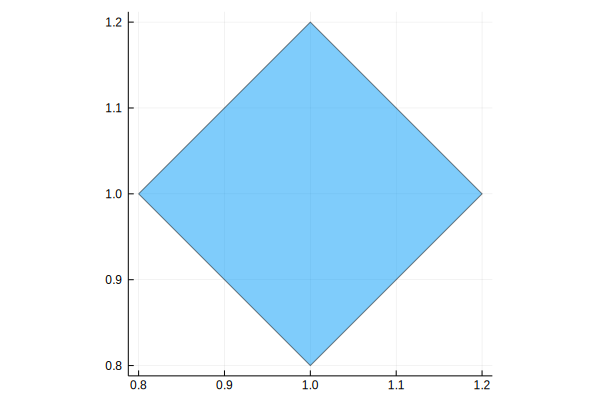

In [5]:
plot(V0)

Let us plot some successors of the sequence $V_k$: 

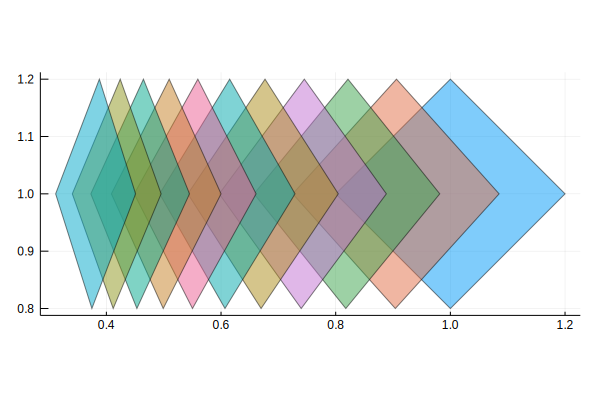

In [6]:
plot!([Φ^k * V0 for k in 1:10])

For the benchmarks we will consider $100$ images ($N$ is 100).

In [7]:
N = 100

100

### Solution by list comprehension

The first, "naive" but simplest approach is to define the sequence by list comprehension. This is perhaps the simplest way to write this function, but we will see that there are more efficient implementations.

In [8]:
function sequence_v1(Φ, V0, N)
    return [linear_map(Φ^k, V0) for k in 0:N-1]
end

sequence_v1 (generic function with 1 method)

In [9]:
@btime res = sequence_v1($Φ, $V0, $N);

  130.125 μs (2196 allocations: 181.42 KiB)


One side note regarding the `linear_map` function of above. That function, in `LazySet`, will just apply the linear map `\Phi` to each vertex of the polygon and is implemented with a call to `broadcast`.

In [10]:
@which linear_map(Φ, V0)

linear_map(M::AbstractArray{N,2}, P::VPolygon{N,VN} where VN<:AbstractArray{N,1}) where N<:Real in LazySets at /Users/forets/.julia/dev/LazySets/src/VPolygon.jl:114

However, `sequence_v1_bare` is slower (why?).

In [11]:
function sequence_v1_bare(Φ, V0, N)
    return [broadcast(v -> Φ^k * v, V0) for k in 0:N-1]
end

sequence_v1_bare (generic function with 1 method)

In [12]:
@btime sequence_v1_bare($Φ, $V0.vertices, $N);

  203.434 μs (3375 allocations: 355.69 KiB)


In [13]:
sequence_v1(Φ, V0, N)[27].vertices

4-element Array{Array{Float64,1},1}:
 [0.0984581, 1.0]
 [0.102026, 0.8] 
 [0.124302, 1.0] 
 [0.120734, 1.2] 

In [14]:
sequence_v1_bare(Φ, V0.vertices, N)[27]

4-element Array{Array{Float64,1},1}:
 [0.0984581, 1.0]
 [0.102026, 0.8] 
 [0.124302, 1.0] 
 [0.120734, 1.2] 

### Preallocating the result and reducing the matrix multiplications

The first improvement consists of noticing that in the list comprehension of above, we compute more matrix powers than needed. For example, if $N = 3$, then the terms $\Phi^2 V_0$ and $\Phi^3 V_0$ require 3 products between $\Phi$ and itself, while if we store the value of $\Phi^k$ and compute $\Phi^3 = \Phi * (\Phi^2)$ we need only two products. In general, from $\Phi^2$ to $\Phi^N$ the naive approach needs $1+\ldots + (N-1) = N(N-1)/2 = (N^2-N)/2$ matrix-matrix products, note that it is quadratic in $N$. On the other hand, if we store the matrix powers of order $k$, only $N-1$ products are needed, and this is linear in $N$.

In [15]:
function sequence_v2(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    res = Vector{LT}(undef, N)
    res[1] = V0
    Φ_power_k = copy(Φ)
    @inbounds for i in 2:N
       res[i] = linear_map(Φ_power_k, V0)
       Φ_power_k = Φ_power_k * Φ
    end
    return res
end

sequence_v2 (generic function with 1 method)

In [16]:
@btime res = sequence_v2($Φ, $V0, $N);

  90.309 μs (1586 allocations: 115.45 KiB)


We have passed from `130us` to `91us`, that makes a 30% reduction in runtime. The total number of allocations has also dropped, from `182kb` to `115kb`.

The function `sequence_v2` can receive any LazySet for which the concrete linear map, `linear_map`, is defined. For instance, we can use it with any higher-dimensional polytope. Consider a similar diamond-shaped set but in dimension 10.

In [17]:
V0_d10 = convert(VPolytope, Ball1(ones(10), 0.2))

VPolytope{Float64}(Array{Float64,1}[[1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [18]:
Φ_d10 = rand(10, 10) .- 0.5

@btime sequence_v1_bare($Φ_d10, $V0_d10.vertices, $N);

  7.704 ms (16063 allocations: 12.18 MiB)


In [19]:
@btime sequence_v2($Φ_d10, $V0_d10, $N);

  346.988 μs (2378 allocations: 424.05 KiB)


In [20]:
344e-6 * 100 / 7.780e-3

4.42159383033419

In [21]:
7.780e-3 / 344e-6

22.61627906976744

The gains are considerably larger in higher dimension; we have passed from a factor 1.4x to a factor 22x.

### Caching the intermediate matrix powers

Now that we reduced the matrix-matrix multiplications, we realize that our algorithm is not very memory-friendly, in the sense that `Φ_power_k = Φ_power_k * Φ` in the "tight-loop" does not re-use the memory allocated by `Φ_power_k`. By adding a new matrix to cache the intermediate matrix-matrix multiplications we can reduce the number of allocations in the loop and hence the garbarge collector (GC) is called less often, with an impact in performance. 

In [22]:
function sequence_v3(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    res = Vector{LT}(undef, N)
    res[1] = V0
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        res[i] = linear_map(Φ_power_k, V0)
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v3 (generic function with 1 method)

In [23]:
@btime res = sequence_v3($Φ, $V0, $N);

  87.979 μs (1488 allocations: 104.73 KiB)


We see that both runtime and allocations have dropped, although only by a marginal value, from `91us` to `87us` and from `115kb` to `104kb`.

In [24]:
100(1 - 87 / 91)

4.395604395604391

Let's check if the difference is more notorious for a larger time horizon:

In [25]:
@btime res = sequence_v2($Φ, $V0, 500);
@btime res = sequence_v3($Φ, $V0, 500);

  457.353 μs (7986 allocations: 581.14 KiB)
  444.220 μs (7488 allocations: 526.67 KiB)


In [26]:
100(1 - 442 / 456), 100(1 - 526 / 581)

(3.0701754385964897, 9.46643717728055)

In [27]:
@btime sequence_v2($Φ_d10, $V0_d10, $N);
@btime sequence_v3($Φ_d10, $V0_d10, $N);

  344.989 μs (2378 allocations: 424.05 KiB)
  343.056 μs (2280 allocations: 338.30 KiB)


In [28]:
100(1 - 342 / 344), 100(1 - 338 / 424)

(0.5813953488372103, 20.28301886792453)

Here the reduction in the total number of allocations is `20%` for the five-dimensional case. Let's consider a 100-dimensional polytope:

In [29]:
V0_d100 = convert(VPolytope, Ball1(ones(100), 0.2))
Φ_d100 = rand(100, 100) .- 0.5

@btime sequence_v2($Φ_d100, $V0_d100, $N);
@btime sequence_v3($Φ_d100, $V0_d100, $N);

  336.538 ms (20298 allocations: 24.73 MiB)
  336.192 ms (20102 allocations: 17.25 MiB)


In [30]:
100(1 - 334 / 337), 100(1 - 17.2 / 24.7)

(0.8902077151335286, 30.364372469635626)

The gain reduction in the number of allocations is now of `30%`. 

### Using statically sized arrays

The following approach consists of using statically sized arrays (the size of the array can be determined from its type) to store the vertices of the polygon and the matrix-matrix and matrix-vector multiplications.

In [31]:
using StaticArrays

Let's consider our fastest version and try if it "just works" if the vertices are statically sized vectors:

First we need to convert the data to static arrays:

In [32]:
Φ

2×2 Array{Float64,2}:
 0.9  0.005
 0.0  1.0  

In [33]:
Φs = SMatrix{2, 2}(Φ)

2×2 SArray{Tuple{2,2},Float64,2,4}:
 0.9  0.005
 0.0  1.0  

In [34]:
V0.vertices[1]

2-element Array{Float64,1}:
 0.8
 1.0

In [35]:
convert(SVector{2}, V0.vertices[1])

2-element SArray{Tuple{2},Float64,1,2}:
 0.8
 1.0

*Note.* The following requires [LazySets#927](https://github.com/JuliaReach/LazySets.jl/issues/927), which at the time of writing is not available yet.

In [36]:
V0s = VPolygon([convert(SVector{2}, vi) for vi in V0.vertices])

VPolygon{Float64,SArray{Tuple{2},Float64,1,2}}(SArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

The version `v3` produces an error in the call to `copy!` function:

In [37]:
sequence_v3(Φs, V0s, N)

ErrorException: setindex!(::SArray{Tuple{2,2},Float64,2,4}, value, ::Int) is not defined.

The function `v2` works, though:

In [38]:
@btime sequence_v2($Φs, $V0s, $N);

  72.370 μs (1783 allocations: 137.00 KiB)


The runtime has dropped from `91us` to `72us`, that's another `20%`.

In [39]:
100(1-72/92)

21.739130434782606

Another option is to use mutable statically sized arrays.

In [40]:
Φm = MMatrix{2, 2}(Φ)
V0m = VPolygon([convert(MVector{2}, vi) for vi in V0.vertices])

VPolygon{Float64,MArray{Tuple{2},Float64,1,2}}(MArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

In [41]:
V0m

VPolygon{Float64,MArray{Tuple{2},Float64,1,2}}(MArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])

Note taht we can pass an `MMatrix` for $\Phi$, and it can be used in combination with `v3`:

In [42]:
@btime sequence_v2($Φm, $V0s, $N);

  74.212 μs (1685 allocations: 132.41 KiB)


In [43]:
@btime sequence_v3($Φm, $V0s, $N);

  65.388 μs (1587 allocations: 127.81 KiB)


This is the fastest result which gets close to a factor 2 improvement over the initial version. 

### Using the formula of $\Phi^k$

For this particular problem, it is easy to obtain the formula for matrix powers. Actually if

$$
M = \begin{pmatrix} a & b \\ 0 & 1 \end{pmatrix},
$$
then for any $k\geq 1$ it holds that:
$$
M^k = \begin{pmatrix} a^k & \dfrac{b ~ (a^k - 1)}{a - 1} \\ 0 & 1 \end{pmatrix}.
$$

In [44]:
function sequence_v4(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    @assert size(Φ) == (2, 2)
    @assert Φ[2, 1] == zero(NT)
    @assert Φ[2, 2] == one(NT)
    a, b = Φ[1, 1], Φ[1, 2]
    @assert a != one(NT)
    
    Φ_power_k(k) = [a^k    b*(a^k - 1)/(a-1) ;
                    0                     1  ]
    
    res = Vector{LT}(undef, N)
    res[1] = V0
    @inbounds for k in 2:N
       res[k] = linear_map(Φ_power_k(k), V0)
    end
    return res
end

sequence_v4 (generic function with 1 method)

In [45]:
@btime sequence_v4($Φ, $V0, $N);

  340.153 μs (3372 allocations: 164.94 KiB)


This version is actually *slower* than the previous ones.

---

### Changing the  representation of `VPolygon`

In this section we explore storing the vertices in matrix form, rather than vector of vectors form.

First, a version that only makes matrix-matrix products:

In [46]:
function sequence_v5(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
end

sequence_v5 (generic function with 1 method)

In [47]:
@btime sequence_v5($Φ, $V0, $N)

  2.419 μs (2 allocations: 224 bytes)


In [48]:
@btime sequence_v5($Φm, $V0, $N)

  708.650 ns (2 allocations: 96 bytes)


Next consider that we also make the matrix-vector products (but we don't store them in an array).

In [49]:
function sequence_v6(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    V0mat = hcat(V0.vertices...)
    ΦV0mat = similar(V0mat)
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(ΦV0mat, Φ_power_k, V0mat)
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
end

sequence_v6 (generic function with 1 method)

In [50]:
@btime sequence_v6($Φ, $V0, $N)

  25.557 μs (8 allocations: 672 bytes)


In [51]:
@btime sequence_v6($Φm, $V0, $N)

  19.884 μs (404 allocations: 22.19 KiB)


In [52]:
# this one is much faster (!): uses mutable arrays both for Φ and for V0
@btime sequence_v6($Φm, $V0m, $N)

  2.784 μs (6 allocations: 352 bytes)


Next suppose that we want to store the results, so we have to transform them back to vector of vectors for storage in `VPolygon`. 

In [53]:
# we need to be able to create a polygon given a matrix, the following helper function is useful
LazySets.VPolygon(M::AbstractMatrix{N}) where {N} = VPolygon([M[:, i] for i in 1:Base.size(M, 2)])

#=
# problem: the rhs doesn't know about VN
LazySets.VPolygon(M::AbstractMatrix{N};
         apply_convex_hull::Bool=true,
         algorithm::String="monotone_chain") where {N<:Real} =
    VPolygon{N, Vector{N}}([M[:, i] for i in 1:Base.size(M, 2)];
                     apply_convex_hull=apply_convex_hull,
                     algorithm=algorithm)
=#

In [54]:
function sequence_v7(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    res = Vector{LT}(undef, N)
    res[1] = V0

    V0mat = hcat(V0.vertices...)
    ΦV0mat = similar(V0mat)
    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(ΦV0mat, Φ_power_k, V0mat)
        res[i] = VPolygon(ΦV0mat)
        #res[i] = VPolygon(ΦV0mat, apply_convex_hull=false)
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v7 (generic function with 1 method)

In [55]:
@btime sequence_v7($Φ, $V0, $N);

  120.979 μs (1593 allocations: 108.27 KiB)


In [56]:
@btime sequence_v7($Φm, $V0, $N);

  103.634 μs (1989 allocations: 129.80 KiB)


In [57]:
@btime sequence_v7($Φm, $V0m, $N);

  62.255 μs (1591 allocations: 83.20 KiB)


It would be interseting to check the overhead in computing the convex hulls upon construction.

Seems like "most" of the time is spent building the `VPolygon`. Let us suppose that we have a `VPolygon` version that stores the vertices in matrix format.

In [58]:
function sequence_v8(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    V0mat = hcat(V0.vertices...)
    ΦV0mat = similar(V0mat)

    res = Vector{typeof(V0mat)}()
    push!(res, V0mat)

    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(ΦV0mat, Φ_power_k, V0mat)
        push!(res, ΦV0mat)
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v8 (generic function with 1 method)

In [59]:
@btime sequence_v8($Φ, $V0, $N);

  34.575 μs (15 allocations: 2.86 KiB)


In [60]:
@btime sequence_v8($Φm, $V0, $N);

  27.895 μs (411 allocations: 24.39 KiB)


In [61]:
@btime sequence_v8($Φm, $V0m, $N);

  9.542 μs (13 allocations: 2.55 KiB)


Let's define this new `LazySet` type and adapt `sequence_v8` accordingly:

In [62]:
# each column represents a point of the polygon
struct VPolygonM{N<:Real, MN<:AbstractMatrix{N}} <: AbstractPolygon{N}
    vertices::MN

    # default constructor that applies a convex hull algorithm
    function VPolygonM(vertices::MN;
                         apply_convex_hull::Bool=true,
                         algorithm::String="monotone_chain") where {N<:Real, MN<:AbstractMatrix{N}}
        #if apply_convex_hull
        #    vlist = [vertices[:, i] for i in 1:Base.size(vertices, 2)]
        #    return new{N, MN}(convex_hull(vlist, algorithm=algorithm))
        #else
            return new{N, MN}(vertices)
        #end
    end
end

In [63]:
function sequence_v9(Φ::AbstractMatrix{NT}, V0::LT, N::Int) where {NT, LT<:LazySet{NT}}
    ΦV0mat = similar(V0.vertices)

    res = Vector{typeof(V0)}()
    push!(res, V0)

    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(ΦV0mat, Φ_power_k, V0.vertices)
        push!(res, VPolygonM(copy(ΦV0mat)))
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v9 (generic function with 1 method)

In [64]:
hcat(V0.vertices...)

2×4 Array{Float64,2}:
 0.8  1.0  1.2  1.0
 1.0  0.8  1.0  1.2

In [65]:
V0M = VPolygonM(hcat(V0.vertices...))

VPolygonM{Float64,Array{Float64,2}}([0.8 1.0 1.2 1.0; 1.0 0.8 1.0 1.2])

In [66]:
@btime sequence_v9($Φm, $V0M, $N);

  23.409 μs (604 allocations: 39.56 KiB)


In [67]:
V0mM = VPolygonM(hcat(V0m.vertices...))

VPolygonM{Float64,MArray{Tuple{2,4},Float64,2,8}}([0.8 1.0 1.2 1.0; 1.0 0.8 1.0 1.2])

In [68]:
@btime sequence_v9($Φm, $V0mM, $N);

  3.781 μs (207 allocations: 11.58 KiB)


In [69]:
V0mM

VPolygonM{Float64,MArray{Tuple{2,4},Float64,2,8}}([0.8 1.0 1.2 1.0; 1.0 0.8 1.0 1.2])

A sanity check:

In [70]:
res_v9 = sequence_v9(Φm, V0mM, N);

In [71]:
res_v9[1].vertices

2×4 MArray{Tuple{2,4},Float64,2,8}:
 0.8  1.0  1.2  1.0
 1.0  0.8  1.0  1.2

In [72]:
res_v9[2].vertices

2×4 MArray{Tuple{2,4},Float64,2,8}:
 0.725  0.904  1.085  0.906
 1.0    0.8    1.0    1.2  

In [73]:
res_v9[14].vertices

2×4 MArray{Tuple{2,4},Float64,2,8}:
 0.24064  0.284019  0.342315  0.298935
 1.0      0.8       1.0       1.2     

In [74]:
res_v1 = sequence_v1(Φ, V0, N);

In [75]:
hcat(res_v1[1].vertices...)

2×4 Array{Float64,2}:
 0.8  1.0  1.2  1.0
 1.0  0.8  1.0  1.2

In [76]:
hcat(res_v1[2].vertices...)

2×4 Array{Float64,2}:
 0.725  0.904  1.085  0.906
 1.0    0.8    1.0    1.2  

In [77]:
res_v2 = sequence_v2(Φ, V0, N);

In [78]:
hcat(res_v2[2].vertices...)

2×4 Array{Float64,2}:
 0.725  0.904  1.085  0.906
 1.0    0.8    1.0    1.2  

In [79]:
hcat(res_v2[14].vertices...)

2×4 Array{Float64,2}:
 0.24064  0.284019  0.342315  0.298935
 1.0      0.8       1.0       1.2     

In [80]:
[res_v9[2].vertices[:, i] for i in 1:4]

4-element Array{MArray{Tuple{2},Float64,1,2},1}:
 [0.725, 1.0]
 [0.904, 0.8]
 [1.085, 1.0]
 [0.906, 1.2]

In [81]:
convex_hull([res_v9[2].vertices[:, i] for i in 1:4])

4-element Array{MArray{Tuple{2},Float64,1,2},1}:
 [0.725, 1.0]
 [0.904, 0.8]
 [1.085, 1.0]
 [0.906, 1.2]

In [82]:
Φ_power_k = copy(Φm)

2×2 MArray{Tuple{2,2},Float64,2,4}:
 0.9  0.005
 0.0  1.0  

In [84]:
ΦV0mat = similar(V0mM.vertices)

2×4 MArray{Tuple{2,4},Float64,2,8}:
 2.35934e-314  2.77248e-318  0.0  0.676734
 0.0           0.0           1.0  1.2     

In [89]:
res_v9 = sequence_v9(Φm, V0mM, N);

In [90]:
res_v2 = sequence_v2(Φ, V0, N);

In [96]:
all([res_v9[i].vertices == hcat(res_v2[i].vertices...) for i in 1:length(res_v9)])

false

In [101]:
res_v9[50].vertices == hcat(res_v2[50].vertices...)

false

In [102]:
res_v9[50].vertices

2×4 MArray{Tuple{2,4},Float64,2,8}:
 0.0542948  0.0454974  0.0565854  0.0653828
 1.0        0.8        1.0        1.2      

In [103]:
hcat(res_v2[50].vertices...)

2×4 Array{Float64,2}:
 0.0454974  0.0565854  0.0653828  0.0542948
 0.8        1.0        1.2        1.0      

Changing the representation to `VPolygonM` has the advantage that we can use a mutable static array for the polygons matrix as well. This makes computations much faster. The downside is that the vertices list is not sorted in counter-clockwise fashion.

With a fast implementation of the convex hull of polygons with four vertices the difference one expects that `VPolygonM` is also fast when the vertices are sorted.

## Using mutable statically sized arrays with VPolygon

In an attempt to understand the difference between using convex hull or not, and using `MArray`'s, consider the following experiment which is a combination of `v3` and `v9`. We will modify `v3` such that it can use `MArray` and convert back to `VPolygon`. 

In [144]:
# based on v3 and v9
function sequence_v10(Φ::AbstractMatrix{NT}, V0::LT, N::Int; apply_convex_hull=true) where {NT, LT<:LazySet{NT}}
    V0mat = hcat(V0.vertices...)
    ΦV0mat = similar(V0mat)

    res = Vector{typeof(V0)}()
    push!(res, V0)

    Φ_power_k = copy(Φ)
    Φ_power_k_cache = similar(Φ)
    @inbounds for i in 2:N
        mul!(ΦV0mat, Φ_power_k, V0mat)
        push!(res, VPolygon([ΦV0mat[:, i] for i in 1:4], apply_convex_hull=apply_convex_hull))
        mul!(Φ_power_k_cache, Φ_power_k, Φ)
        copy!(Φ_power_k, Φ_power_k_cache)
    end
    return res
end

sequence_v10 (generic function with 1 method)

In [142]:
@btime sequence_v10($Φm, $V0m, $N);

  91.260 μs (1696 allocations: 86.08 KiB)


In [146]:
@btime sequence_v10($Φm, $V0m, $N, apply_convex_hull=false);

  48.105 μs (904 allocations: 33.48 KiB)


In [120]:
res_10 = sequence_v10(Φm, V0m, N);

VPolygon{Float64,MArray{Tuple{2},Float64,1,2}}(MArray{Tuple{2},Float64,1,2}[[0.8, 1.0], [1.0, 0.8], [1.2, 1.0], [1.0, 1.2]])